# Optimised Evaluation of MobileNet V2 and ResNet-18 using CIFAR-10 and CIFAR-100

In this notebook, we will evaluate the whole project, so we will take into account two distinct architectures MobileNetV2 (optimized for efficiency) and ResNet-18 (optimized for feature extraction accuracy) on the two datasets CIFAR-10 and CIFAR-100.

> Main questions we aim to answer:
- Which model is better?
- Which training strategy is better?
- What is the best performance?
- Where does models fail?
- At what computational cost?

## Setup

In [1]:
import os, sys, time, torch, dataframe_image as dfi, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sb
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from typing import List, Optional

from pathlib import Path
ROOT = Path().resolve().parent
sys.path.insert(0, str(ROOT))

from model import TransferModel

from data_preparation.CIFAR_10.data_cifar_10 import test_loader as test_loader_10
from data_preparation.CIFAR_100.data_cifar_100 import test_loader as test_loader_100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
The size of training set is 45000 samples
The size of validation set is 5000 samples
Running on: cpu


Import class labels for the CIFAR-10 and CIFAR-100.

In [2]:
class_labels_10 = test_loader_10.dataset.classes
class_labels_100 = test_loader_100.dataset.classes

class_labels_10[:5], class_labels_100[:5]

(['airplane', 'automobile', 'bird', 'cat', 'deer'],
 ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver'])

Helper list (only for plotting).

In [3]:
strategy_labels = ['Head-Only', 'Last-Block', 'Fine-Tuning']
model_names = ['MobileNetV2', 'ResNet-18']
dataset_names = ["CIFAR-10",'CIFAR-100']

Helper function that streamlines the model evaluation data by retrieving training histories across multiple transfer learning strategies, calculating generalization gaps, and initializing the specific model architecture with its best-performing weights and descriptive class labels.

In [4]:
def load_data(dataset, model_name: str, device: str, class_labels: list[str] = None):
    base_path = ROOT / f"data_evaluation_{model_name}" / dataset
    
    dataset_path_name = dataset.lower().replace('_', '') # CIFAR_100 -> cifar100
    num_classes = int(dataset.replace('CIFAR_', '')) # CIFAR_100 -> 100

    # Load history for each strategy
    histories = {strategy_labels[i]: pd.read_csv(base_path / f"{model_name}_{dataset_path_name}_{s}_best_training_history.csv") for i,s in enumerate(["head","lastblock", "full"]) }
    # Calculate Generalisation gap
    for df in histories.values(): df['gap'] = df['val_loss'] - df['train_loss']

    # Load predictions
    preds = pd.read_csv(base_path / f"{model_name}_test_predictions.csv")
    
    if class_labels:
        # mappind IDs to class labels
        y_true = [class_labels[i] for i in preds.True_Label]
        y_pred = [class_labels[i] for i in preds.Predicted_Label]
    else:
        # leave IDs for classes
        y_true = preds['True_Label'].tolist()
        y_pred = preds['Predicted_Label'].tolist()

    # Load model structure
    model = TransferModel(num_classes=num_classes, backbone=model_name, pretrained=True).to(device)

    # Load weights
    weights_path = base_path / f"{model_name}_{dataset_path_name}_full_best.pth"
    model.load_state_dict(torch.load(weights_path, map_location=device))

    return histories, [y_true, y_pred], [model, weights_path]

Separate import for CIFAR-10 and CIFAR-100 by model's architectures.

In [5]:
# For CIFAR-10
mobilenet_10_history, mobilenet_10_list_pred, mobilenet_10_model = load_data("CIFAR_10", "mobilenet_v2", device, class_labels=class_labels_10)
resnet_10_history, resnet_10_list_pred, resnet_10_model = load_data("CIFAR_10", "resnet18", device,  class_labels=class_labels_10)
history_cifar_10 = [
    [mobilenet_10_history[key] for key in strategy_labels], # took df from dict
    [resnet_10_history[key] for key in strategy_labels]
]

# For CIFAR-100
mobilenet_100_history, mobilenet_100_list_pred, mobilenet_100_model = load_data("CIFAR_100", "mobilenet_v2", device, class_labels=class_labels_100)
resnet_100_history, resnet_100_list_pred, resnet_100_model = load_data("CIFAR_100", "resnet18", device,  class_labels=class_labels_100)
history_cifar_100 = [
    [mobilenet_100_history[key] for key in strategy_labels],
    [resnet_100_history[key] for key in strategy_labels]
]

## Slide 1: Training & Global Metrics

Helper function for plotting.

In [6]:
def plot_training_analytics(list_dfs: List[List[pd.DataFrame]], model_names: List[str], ax: plt.Axes, metric: str, title: str = "", axis_labels: Optional[List[str]] = None, strategy_labels: Optional[List[str]] = None):

    linestyles = ['-',':', '--'] 
    colors = ['blue', 'orange'] 

    for model_idx, model_strategies in enumerate(list_dfs): # Loop over Models
        color = colors[model_idx] # for new model new color

        for strat_idx, df in enumerate(model_strategies): # Loop over Strategies
            linestyle = linestyles[strat_idx] # for new strategy new linestyle

            label = f"{model_names[model_idx]} ({strategy_labels[strat_idx]})"
            
            ax.plot(df.index, df[metric], label=label, linestyle=linestyle, color=color) #linewidth=2, alpha=0.85
                
    if axis_labels: 
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)
    ax.legend()

                                                                            Validation accuracy curves                                                                                                    

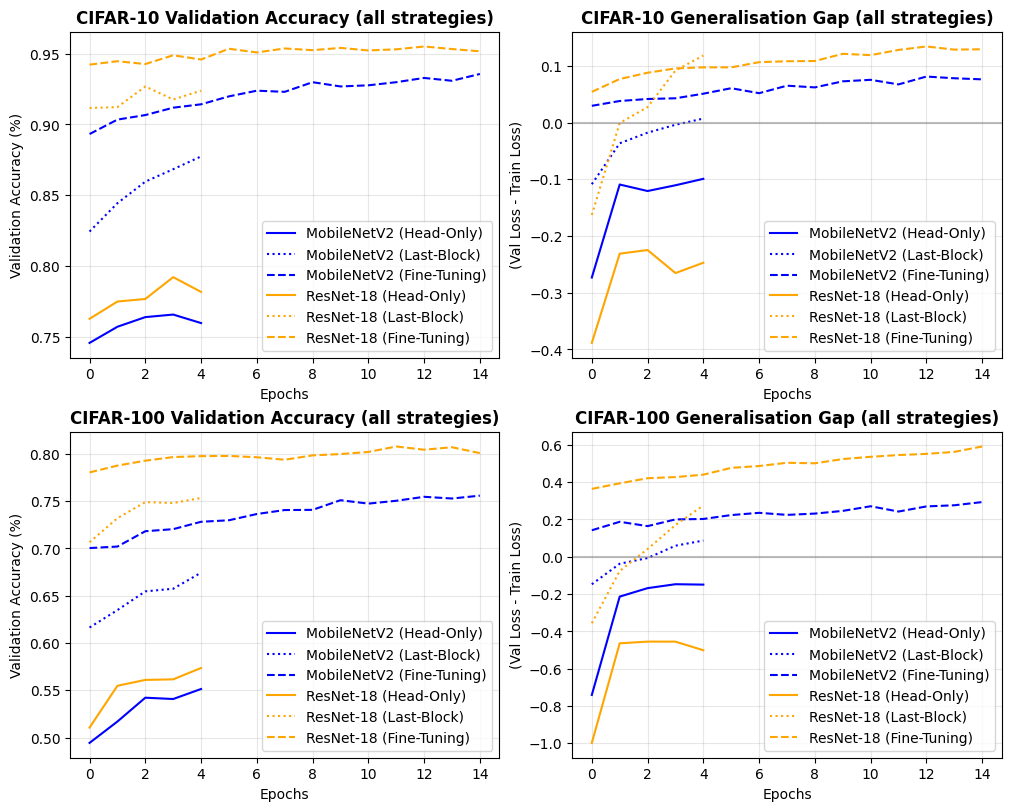

In [7]:
fig, ax = plt.subplots(2,2, figsize=(10, 8), layout='constrained') # whole 2,2 (10, 8) -> on slides 1,2 (10, 4)

for i, df in enumerate([history_cifar_10,history_cifar_100]):

    plot_training_analytics(
        list_dfs=df,                   # The list of lists
        model_names=model_names,       # ['MobileNetV2', 'ResNet-18']
        ax=ax[i,0],                         # The matplotlib axis
        metric='val_acc',             # The metric to plot (args*)
        title=f"{dataset_names[i]} Validation Accuracy (all strategies)",
        axis_labels=["Epochs", "Validation Accuracy (%)"],
        strategy_labels=strategy_labels         # ['Head-Only', 'Last-Block', 'Fine-Tuning']
    )

    plot_training_analytics(
        list_dfs=df,                   # The list of lists
        model_names=model_names,       # ['MobileNetV2', 'ResNet-18']
        ax=ax[i,1],                         # The matplotlib axis
        metric='gap',             # The metric to plot (args*)
        title=f"{dataset_names[i]} Generalisation Gap (all strategies)",
        axis_labels=["Epochs", "(Val Loss - Train Loss)"],
        strategy_labels=strategy_labels         # ['Head-Only', 'Last-Block', 'Fine-Tuning']
    )
    ax[i,1].axhline(y=0,color='grey' , alpha=0.5)

plt.show()

                                                                            Max accuracy barplot (per strategy)                                                                                                    

Collect all information into one DataFrame.

In [8]:
lr_map = {
    'Head-Only': 0.001,
    'Last-Block': 0.0001,
    'Fine-Tuning': 0.00001
}

experiments = [
    ("CIFAR-10",  history_cifar_10),
    ("CIFAR-100", history_cifar_100)
]

summary_data_list = []


for idx_dataset, history_container in enumerate( [history_cifar_10, history_cifar_100]):
    
    for i, model_dfs in enumerate(zip(*history_container)):
        current_strategy = strategy_labels[i]
        current_lr = lr_map.get(current_strategy, 0.00001)
        
        # Iterate through the models in this strategy group
        for model_idx, df in enumerate(model_dfs):
            # Calculate Percentage
            max_acc_pct = df['val_acc'].max() * 100
            
            # Append Row
            summary_data_list.append([
                current_strategy,                # Strategy
                model_names[model_idx],          # Model Name (mapped by index)
                max_acc_pct,                     # Max Acc
                len(df),                         # Epochs
                'Imagenet',                      # Weights
                dataset_names[idx_dataset],                    # Dataset Name
                current_lr                       # Learning Rate
            ])


summary_table = pd.DataFrame(summary_data_list, columns=[
    'Training Strategy', 'Model', 'Maximum Val Accuracy', 
    'Epochs', 'Initial Weights', 'Dataset', 'Learning Rate'
])

# Apply Styling
styled_global = summary_table.style.format({
    'Maximum Val Accuracy': '{:.2f}%',
    'Learning Rate': '{:.5f}' # Added format for cleaner LR display
}).hide(axis='index')

display(styled_global)

Training Strategy,Model,Maximum Val Accuracy,Epochs,Initial Weights,Dataset,Learning Rate
Head-Only,MobileNetV2,76.58%,5,Imagenet,CIFAR-10,0.00100
Head-Only,ResNet-18,79.22%,5,Imagenet,CIFAR-10,0.00100
Last-Block,MobileNetV2,87.74%,5,Imagenet,CIFAR-10,0.00010
Last-Block,ResNet-18,92.68%,5,Imagenet,CIFAR-10,0.00010
Fine-Tuning,MobileNetV2,93.56%,15,Imagenet,CIFAR-10,0.00001
Fine-Tuning,ResNet-18,95.50%,15,Imagenet,CIFAR-10,0.00001
Head-Only,MobileNetV2,55.14%,5,Imagenet,CIFAR-100,0.00100
Head-Only,ResNet-18,57.36%,5,Imagenet,CIFAR-100,0.00100
Last-Block,MobileNetV2,67.44%,5,Imagenet,CIFAR-100,0.00010
Last-Block,ResNet-18,75.34%,5,Imagenet,CIFAR-100,0.00010


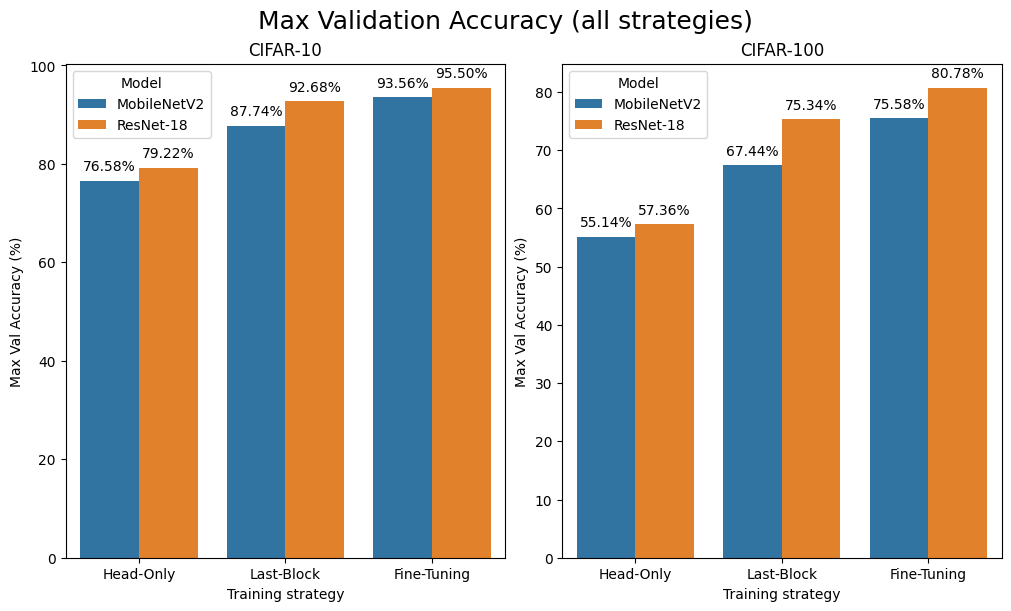

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10, 6), layout='constrained') # whole 2,2 (10, 8) -> on slides 1,2 (10, 4)

plt.suptitle("Max Validation Accuracy (all strategies)", fontsize=18)

def plot(summary_table, dataset, ax,title):
    ax1 = sb.barplot(data=summary_table[summary_table['Dataset']==dataset], x="Training Strategy", y="Maximum Val Accuracy", hue="Model", ax=ax)

    for container in ax.containers:
        ax1.bar_label(container, fmt='%.2f%%', padding=5) # add percentage on top of bars

    ax.set_title(title) 
    ax.set_ylabel("Max Val Accuracy (%)")
    ax.set_xlabel('Training strategy')

for i,data_name in enumerate(dataset_names):
    plot(summary_table,data_name, ax[i], data_name)

plt.show()

                                                                            Global metrics table                                                                                                    

In [10]:
report_mobilinet_10 = classification_report(mobilenet_10_list_pred[0], mobilenet_10_list_pred[1], output_dict=True)
report_resnet_10 = classification_report(resnet_10_list_pred[0], resnet_10_list_pred[1], output_dict=True)
report_mobilinet_100 = classification_report(mobilenet_100_list_pred[0], mobilenet_100_list_pred[1], output_dict=True)
report_resnet_100 = classification_report(resnet_100_list_pred[0], resnet_100_list_pred[1], output_dict=True)

In [11]:
def extract_global_metrics(report, model_name,data):
    return {
        'Model': model_name,
        'Data':data,
        'Accuracy': report['accuracy'],
        'Macro F1': report['macro avg']['f1-score'],
        'Weighted F1': report['weighted avg']['f1-score'],
        'Macro Recall': report['macro avg']['recall']
    }

In [12]:
metrics_data = [
    extract_global_metrics(report_mobilinet_10, 'MobileNetV2', 'CIFAR10'),
    extract_global_metrics(report_resnet_10,'ResNet-18' , 'CIFAR10'),
    extract_global_metrics(report_mobilinet_100, 'MobileNetV2', 'CIFAR100'),
    extract_global_metrics(report_resnet_100,'ResNet-18', 'CIFAR100' )
]

df_global_metrics = pd.DataFrame(metrics_data)

styled_global = df_global_metrics.style.format({
    'Accuracy': '{:.2%}',
    'Macro F1': '{:.2%}',
    'Weighted F1': '{:.2%}',
    'Macro Recall': '{:.2%}'
}).hide(axis='index')

display(styled_global)

Model,Data,Accuracy,Macro F1,Weighted F1,Macro Recall
MobileNetV2,CIFAR10,93.23%,93.24%,93.24%,93.23%
ResNet-18,CIFAR10,94.83%,94.82%,94.82%,94.83%
MobileNetV2,CIFAR100,75.89%,75.87%,75.87%,75.89%
ResNet-18,CIFAR100,80.22%,80.22%,80.22%,80.22%


## Slide 2: Error Analysis + Efficiency

In [13]:
report_mobilinet_10 = classification_report(mobilenet_10_list_pred[0], mobilenet_10_list_pred[1], output_dict=True)
report_resnet_10 = classification_report(resnet_10_list_pred[0], resnet_10_list_pred[1], output_dict=True)
report_mobilinet_100 = classification_report(mobilenet_100_list_pred[0], mobilenet_100_list_pred[1], output_dict=True)
report_resnet_100 = classification_report(resnet_100_list_pred[0], resnet_100_list_pred[1], output_dict=True)


In [14]:
def process_classification_reports(reports, model_names):

    df_list = []

    for report, model_name in zip(reports, model_names):

        temp_df = pd.DataFrame(report).transpose().reset_index() # get classes as row
        
        temp_df = temp_df.rename(columns={'index': 'Class Label'}) # rename
        
        temp_df['Model'] = model_name # model indentificator
    
        df_list.append(temp_df)


    df_result = pd.concat(df_list, ignore_index=True) # make df

  
    summary_rows = ['accuracy', 'macro avg', 'weighted avg']
    # FIX: Use df_result here
    df_result = df_result[~df_result['Class Label'].isin(summary_rows)] 
    df_result = df_result.reset_index(drop=True)

    # 3. Scale it (Now we are scaling the cleaned data)
    cols_to_scale = ['precision', 'recall', 'f1-score']
    df_result[cols_to_scale] = df_result[cols_to_scale] * 100

    return df_result

In [15]:
report_df_cifar_10 = process_classification_reports([report_mobilinet_10, report_resnet_10],['MobileNetV2','ResNet-18'])
report_df_cifar_10.head(5)

,Class Label,precision,recall,f1-score,support,Model
0,airplane,94.388778,94.2,94.294294,1000.0,MobileNetV2
1,automobile,96.576032,95.9,96.236829,1000.0,MobileNetV2
2,bird,95.729167,91.9,93.775510,1000.0,MobileNetV2
3,cat,85.300000,85.3,85.300000,1000.0,MobileNetV2
4,deer,92.430279,92.8,92.614770,1000.0,MobileNetV2


In [16]:
report_df_cifar_100 = process_classification_reports([report_mobilinet_100, report_resnet_100],['MobileNetV2','ResNet-18'])
report_df_cifar_100.head(5)

,Class Label,precision,recall,f1-score,support,Model
0,apple,94.845361,92.0,93.401015,100.0,MobileNetV2
1,aquarium_fish,86.407767,89.0,87.684729,100.0,MobileNetV2
2,baby,70.652174,65.0,67.708333,100.0,MobileNetV2
3,bear,71.590909,63.0,67.021277,100.0,MobileNetV2
4,beaver,53.571429,60.0,56.603774,100.0,MobileNetV2


                                                                            Per-Class Performance Analytics                                                                                                    

In [17]:
def plot_class_analytics(df, ax, metric:str, interval=None, title:str=None,axis_labels=None,percentage=False,order=None):  
    """
    Args:
        df: single DataFrame
        ax: matplotlib axis
        *metrics: column names to plot
        interval: [min, max] to enforce y-axis limits
        title: main title for the subplot
        axis_labels: [x_label, y_label]
    Returns:
        None
    """
    ax = sb.barplot(data=df, x="Class Label", y=metric, hue = "Model" if "Model" in df.columns else None, ax=ax,order=order) #palette='viridis'
  
    if df.shape[0]>20:
        ax.tick_params(axis='x', rotation=90, labelsize=6)

    if axis_labels: 
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])
    if percentage:
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', padding=5) # add percentage on top of bars
    

    if title: ax.set_title(title)
    if interval: ax.set_ylim(interval[0], interval[1])
    # ax.grid(alpha=0.2, axis='y')

### For CIFAR-10

Index(['MobileNetV2', 'ResNet-18', 'diff'], dtype='object', name='Model')


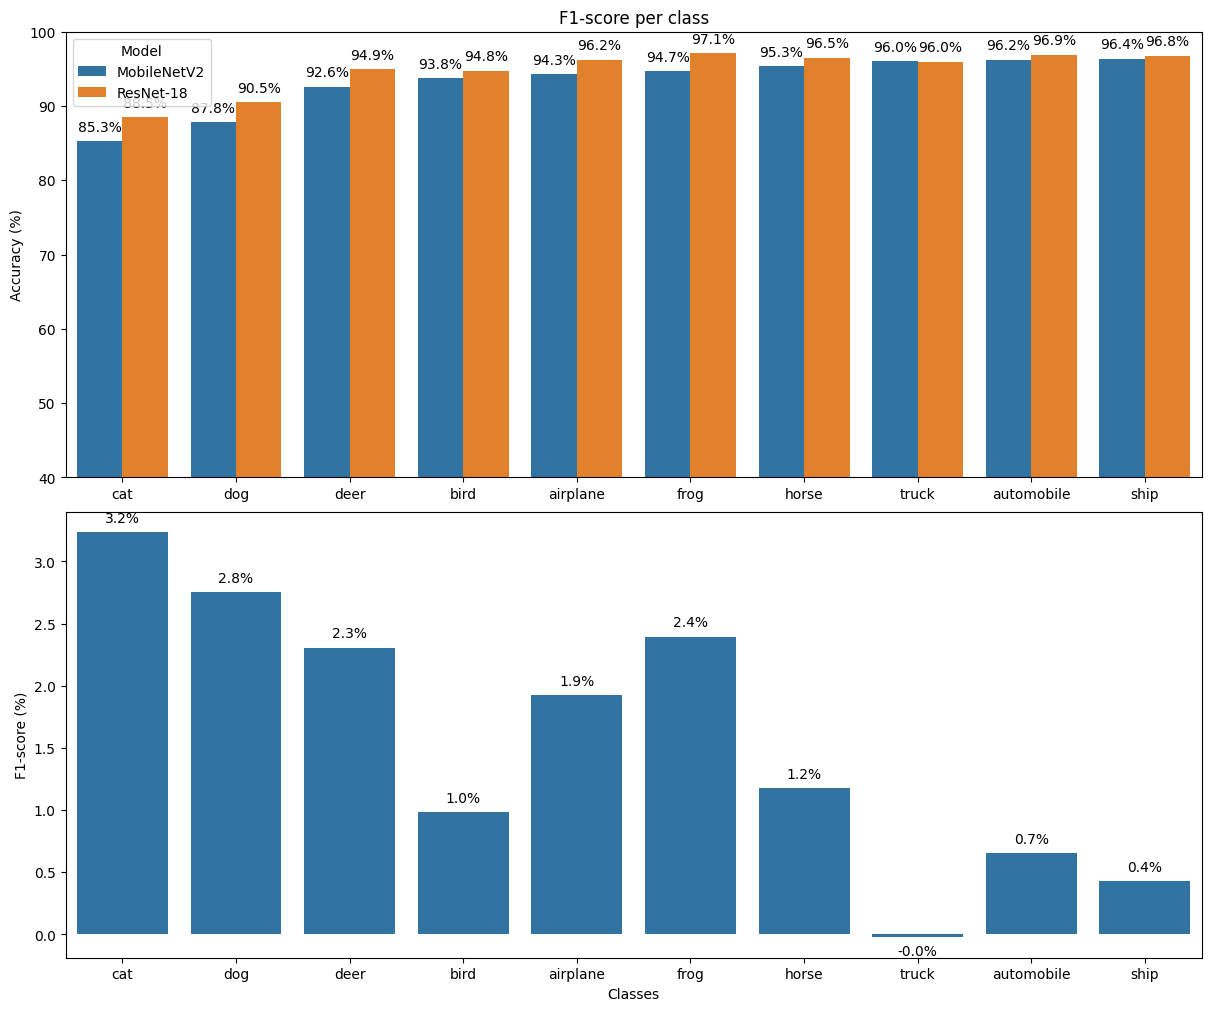

In [18]:
sort_classes = (
    report_df_cifar_10
    .groupby('Class Label')['f1-score']
    .mean()
    .sort_values()
    .index
)

fig, ax = plt.subplots(2,1,figsize=(12, 10), layout="constrained") #(12, 15)

plot_class_analytics(report_df_cifar_10,ax[0],'f1-score', title='F1-score per class', interval=[40,100], axis_labels=['','Accuracy (%)'],order= sort_classes,percentage=True)


# plot_class_analytics(df_per_class_scaled,ax[1],'recall', title='Recall metric per class', interval=[80,100], axis_labels=['','Recall (%)'],percentage=True)

#--
df_wide = report_df_cifar_10.pivot(index='Class Label', columns='Model', values='f1-score')

df_wide['diff'] = df_wide['ResNet-18'] - df_wide['MobileNetV2']

df_wide = df_wide.sort_values('diff')
print(df_wide.columns)
plot_class_analytics(df_wide, ax[1],'diff',  axis_labels=['Classes','F1-score (%)'],order= sort_classes,percentage=True) #title='F1-score metric per class',


plt.show()



In [19]:
#for cifar 10
mobilinet_10_overall_confusion_matrix = confusion_matrix(mobilenet_10_list_pred[0], mobilenet_10_list_pred[1]) #,normalize='true'
resnet_10_overall_confusion_matrix = confusion_matrix(resnet_10_list_pred[0], resnet_10_list_pred[1]) #,normalize='true'

In [20]:
def get_top_confusions(cm_: np.ndarray, class_labels: list[str], top_n: int = 5, model: str = '') -> pd.DataFrame:
    """
    Returns a DataFrame of the top N confusion pairs (most frequent misclassifications).
    
    Args:
        cm_ : confusion matrix (numpy array)
        class_labels : list of class names corresponding to cm_ rows/columns
        top_n : number of top confusions to return
        model : optional model name for labeling
    
    Returns:
        pd.DataFrame with columns: ['True Class', 'Predicted Class', 'Count']
    """
    
    cm = cm_.copy()
    np.fill_diagonal(cm, 0)  # ignore correct predictions
    
    pairs = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0:
                pairs.append((f'{class_labels[i]} -> {class_labels[j]}',cm[i, j],class_labels[i], class_labels[j])) # *100
    
    df = pd.DataFrame(pairs, columns=['Confusion Pair', 'Count', 'True Class', 'Predicted Class'])
    df = df.sort_values('Count', ascending=False).iloc[:top_n].reset_index(drop=True)
    
    if model:
        df.insert(0, 'Model', model)
    
    return df

In [21]:
df_mobi = get_top_confusions(mobilinet_10_overall_confusion_matrix ,model='MobileNetV2', class_labels=class_labels_10, top_n=5)
df_res=get_top_confusions(resnet_10_overall_confusion_matrix,model='ResNet-18', class_labels=class_labels_10, top_n=5)

df_10_combined = pd.concat([df_mobi,df_res]).sort_values(by=['True Class','Predicted Class','Model']).reset_index(drop=True)
df_10_combined

,Model,Confusion Pair,Count,True Class,Predicted Class
0,ResNet-18,airplane -> ship,20,airplane,ship
1,MobileNetV2,automobile -> truck,24,automobile,truck
2,ResNet-18,automobile -> truck,27,automobile,truck
3,MobileNetV2,cat -> dog,80,cat,dog
4,ResNet-18,cat -> dog,89,cat,dog
5,MobileNetV2,cat -> frog,26,cat,frog
6,MobileNetV2,dog -> cat,76,dog,cat
7,ResNet-18,dog -> cat,40,dog,cat
8,MobileNetV2,truck -> automobile,22,truck,automobile
9,ResNet-18,truck -> automobile,23,truck,automobile


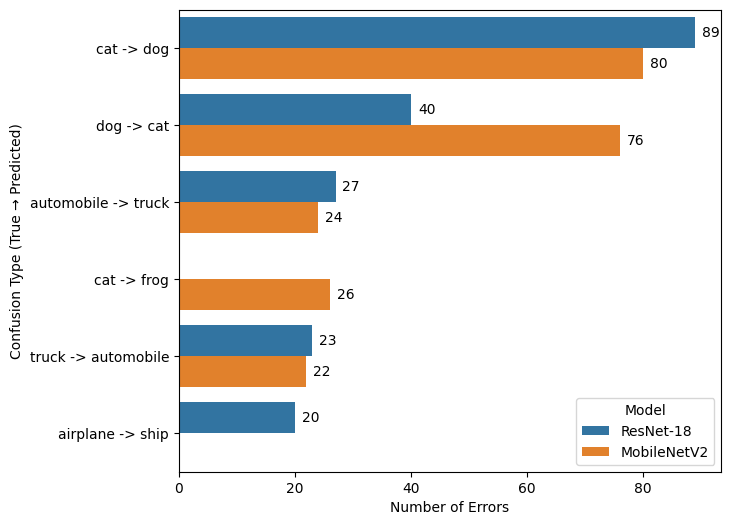

In [22]:

plt.figure(figsize=(7, 6))

ax = sb.barplot(
    data=df_10_combined.sort_values('Count', ascending=False), 
    x="Count", 
    y="Confusion Pair", 
    hue="Model", 
    
)

for container in ax.containers:
    ax.bar_label(container, padding=5) # add percentage on top of bars
    

#plt.title("Top Confusion Pairs: Model Comparison", fontsize=16)
plt.xlabel("Number of Errors")
plt.ylabel("Confusion Type (True → Predicted)")

plt.legend(title='Model')

plt.show()

### For CIFAR-100

Index(['MobileNetV2', 'ResNet-18', 'diff'], dtype='object', name='Model')


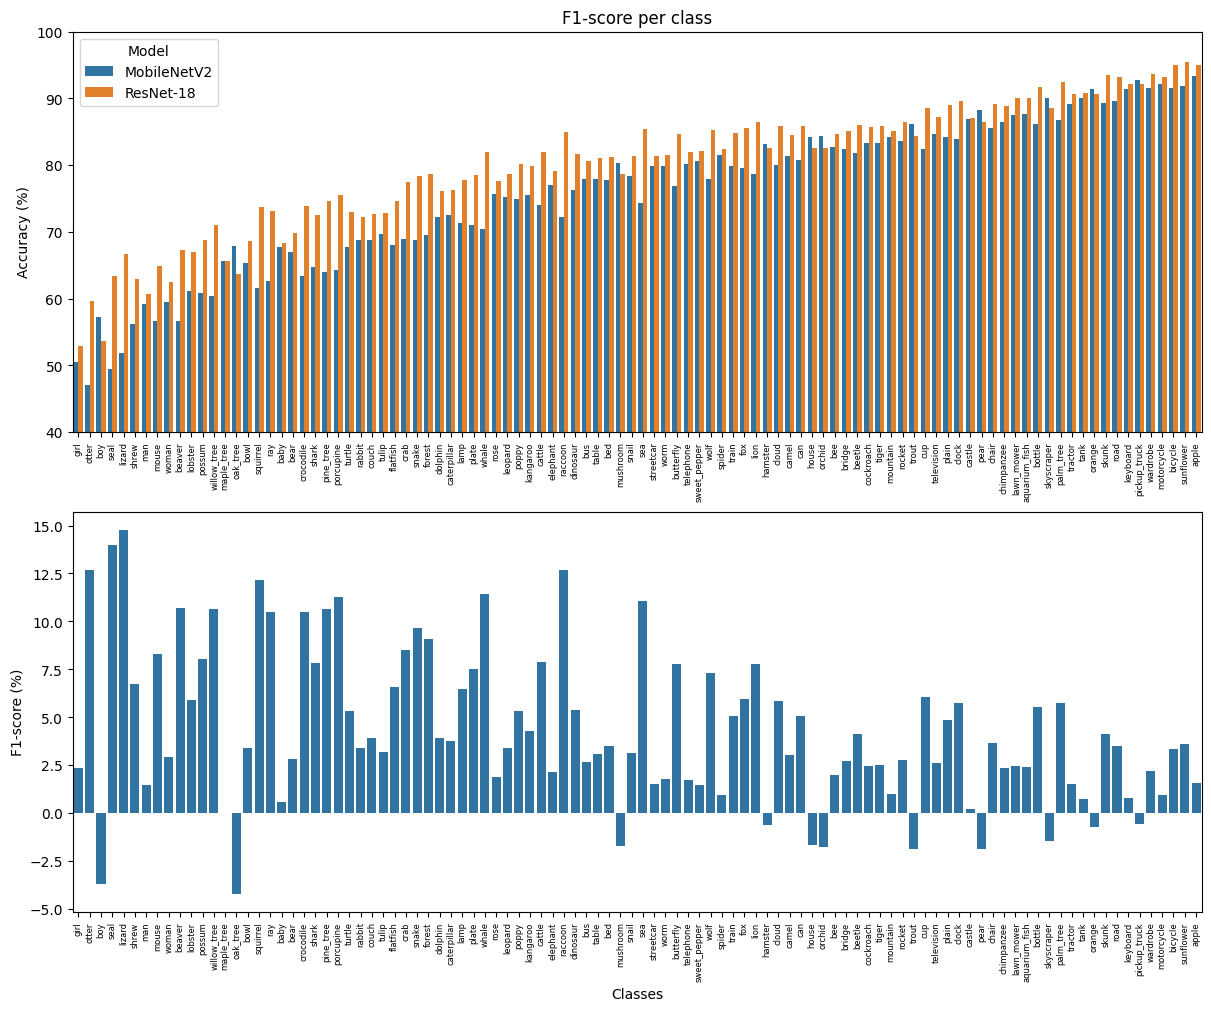

In [23]:
sort_classes = (
    report_df_cifar_100
    .groupby('Class Label')['f1-score']
    .mean()
    .sort_values()
    .index
)

fig, ax = plt.subplots(2,1,figsize=(12, 10), layout="constrained") #(12, 15)

plot_class_analytics(report_df_cifar_100,ax[0],'f1-score', title='F1-score per class', interval=[40,100], axis_labels=['','Accuracy (%)'],order= sort_classes)


# plot_class_analytics(df_per_class_scaled,ax[1],'recall', title='Recall metric per class', interval=[80,100], axis_labels=['','Recall (%)'],percentage=True)

#--
df_wide = report_df_cifar_100.pivot(index='Class Label', columns='Model', values='f1-score')


df_wide['diff'] = df_wide['ResNet-18'] - df_wide['MobileNetV2']


df_wide = df_wide.sort_values('diff')
print(df_wide.columns)
plot_class_analytics(df_wide, ax[1],'diff',  axis_labels=['Classes','F1-score (%)'],order= sort_classes) #title='F1-score metric per class',


plt.show()



If positive → ResNet better

If negative → MobileNet better

In [24]:
#for cifar 100
mobilinet_100_overall_confusion_matrix = confusion_matrix(mobilenet_100_list_pred[0], mobilenet_100_list_pred[1]) #,normalize='true'
resnet_100_overall_confusion_matrix = confusion_matrix(resnet_100_list_pred[0], resnet_100_list_pred[1]) #,normalize='true'

In [25]:
df_mobi = get_top_confusions(mobilinet_100_overall_confusion_matrix ,model='MobileNetV2', class_labels=class_labels_100, top_n=5)
df_res=get_top_confusions(resnet_100_overall_confusion_matrix,model='ResNet-18', class_labels=class_labels_100, top_n=5)

df_100_combined = pd.concat([df_mobi,df_res]).sort_values(by=['True Class','Predicted Class','Model']).reset_index(drop=True)
df_100_combined

,Model,Confusion Pair,Count,True Class,Predicted Class
0,ResNet-18,baby -> boy,14,baby,boy
1,MobileNetV2,boy -> man,18,boy,man
2,MobileNetV2,girl -> woman,18,girl,woman
3,ResNet-18,girl -> woman,20,girl,woman
4,ResNet-18,man -> boy,17,man,boy
5,MobileNetV2,maple_tree -> oak_tree,17,maple_tree,oak_tree
6,ResNet-18,maple_tree -> oak_tree,18,maple_tree,oak_tree
7,ResNet-18,oak_tree -> maple_tree,19,oak_tree,maple_tree
8,MobileNetV2,seal -> otter,19,seal,otter
9,MobileNetV2,woman -> girl,18,woman,girl


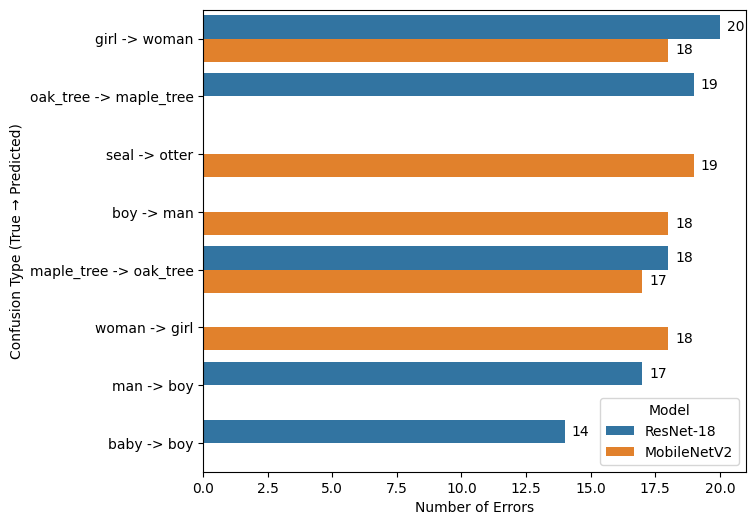

In [26]:

plt.figure(figsize=(7, 6))

ax = sb.barplot(
    data=df_100_combined.sort_values('Count', ascending=False), 
    x="Count", 
    y="Confusion Pair", 
    hue="Model", 
    
)

for container in ax.containers:
    ax.bar_label(container, padding=5) # add percentage on top of bars
    

#plt.title("Top Confusion Pairs: Model Comparison", fontsize=16)
plt.xlabel("Number of Errors")
plt.ylabel("Confusion Type (True → Predicted)")

plt.legend(title='Model')

plt.show()

## Additional: Model Inference

In [27]:
def visualize_model_predictions(model, loader, class_labels,  target_class=None, num_images=5, device="cpu"):
    samples = []
    
    if target_class is not None:  target_class_id = class_labels.index(target_class) 
    
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for images, labels in loader: 
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            # Define filter
            if target_class:
                mask = (labels == target_class_id) & (preds != target_class_id)
            else:
                mask = torch.ones_like(labels, dtype=torch.bool)
            
            # Store matching images
            if mask.any():
                for img, t, p in zip(images[mask], labels[mask], preds[mask]):
                    samples.append((img.cpu(), t.item(), p.item()))
                    if len(samples) >= num_images: break
            
            if len(samples) >= num_images: break
        
    if not samples: return print("No images found.")

    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    plt.figure(figsize=(10,5))
    for i in range(num_images) :
        img_tensor, true_id, pred_id = samples[i]
        plt.subplot(1,5,i+1)
        img = img_tensor.permute(1, 2, 0).numpy()
        img = (std * (img) + mean) 

        plt.axis("off")
        plt.title(f"True : {class_labels[true_id]}, Pred: {class_labels[pred_id]}",fontsize=10)
        plt.imshow(img)
    plt.show()

In [28]:
#visualize_model_predictions(resnet_10[2], test_loader_10,class_labels=class_labels_10,target_class='cat')
#visualize_model_predictions(mobilenet_10[2], test_loader_10,class_labels=class_labels_10,target_class='cat')

## Conclusion Slide: Efficiency Analysis

In [ ]:
def get_efficiency_metrics(model, loader, device, model_path, model_name):
    model.eval()

    #model size
    size_mb = os.path.getsize(model_path) / (1024 * 1024)

    #total numb of parameters
    params = sum(p.numel() for p in model.parameters())
    
    num_samples = 0
    start_time = time.time()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            num_samples += images.size(0)
            
            if i >= 10: break 
            
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / num_samples
    df=[]
    df.append([model_name,'CIFAR-100',size_mb,params,avg_inference_time])
    return pd.DataFrame(df,columns=['Model', 'Data','Model Size','Total Params','Inference Time (s)'])

df_res_10 = get_efficiency_metrics(resnet_10_model[0], test_loader_10, device, resnet_10_model[1],
    'ResNet-18') 
df_mobi_10= get_efficiency_metrics(mobilenet_10_model[0], test_loader_10, device, mobilenet_10_model[1],
    'MobileNetV2'
)
df_res_100 = get_efficiency_metrics(resnet_100_model[0], test_loader_10, device, resnet_100_model[1],
    'ResNet-18') 
df_mobi_100= get_efficiency_metrics(mobilenet_100_model[0], test_loader_10, device, mobilenet_10_model[1],
    'MobileNetV2'
)

df_eff= pd.concat([df_mobi_10,df_res_10,df_mobi_100,df_res_100]).reset_index(drop=True)
df_eff

,Model,Data,Model Size,Total Params,Inference Time (s)
0,MobileNetV2,CIFAR-100,8.775284,2236682,0.022031
0,ResNet-18,CIFAR-100,42.733238,11181642,0.023682
0,MobileNetV2,CIFAR-100,8.775284,2351972,0.022152
0,ResNet-18,CIFAR-100,42.909923,11227812,0.023177
